### Optimal control of phenomenological models, e.g. the model model
This notebook shows how to compute the optimal control (OC) signal for the model model for a simple example task. For the Hopf-model the OC can be computed completely analogously.

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [62]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 10.
amplitude = 1.
period = duration / 4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.011225367461896877
y_init = 0.013126741089502588
model.params["exc_init"] = np.array([[x_init]])
model.params["inh_init"] = np.array([[y_init]])

0.011225367461896877
0.013126741089502588


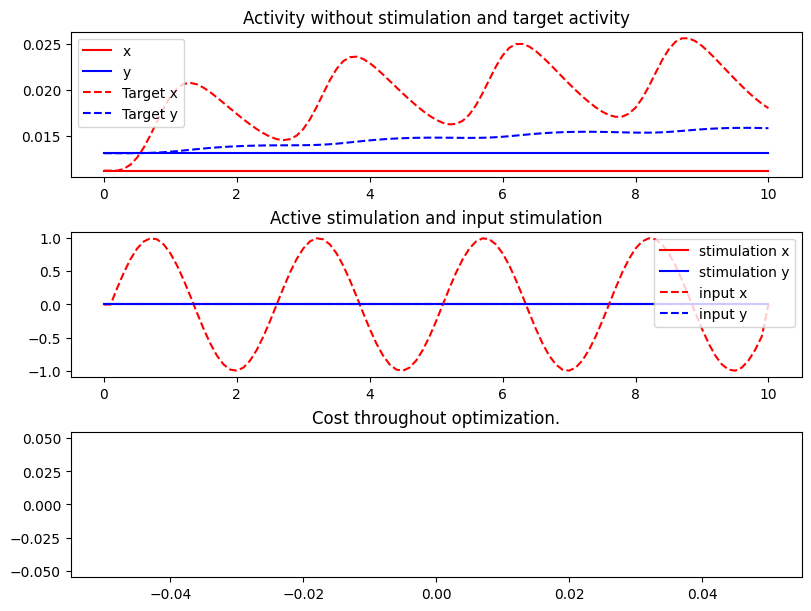

In [63]:
# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input
model.params["inh_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

print(state[0,0,-1])
print(state[0,1,-1])

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 0: 41.810554198290326
Cost in iteration 1: 6.349688562132673
Cost in iteration 2: 4.4558921888798135
Cost in iteration 3: 3.897192135793106
Cost in iteration 4: 3.848504227562522
Cost in iteration 5: 3.278847675429431
Cost in iteration 6: 3.2696215246558307
Cost in iteration 7: 2.8554494373993022
Cost in iteration 8: 2.289715201801963
Cost in iteration 9: 2.092894301681858
Cost in iteration 10: 2.0006797198601087
Cost in iteration 11: 1.8923202470449096
Cost in iteration 12: 1.8484989539038121
Cost in iteration 13: 1.7664052827147885
Cost in iteration 14: 1.5092003311820261
Cost in iteration 15: 1.4018524147444504
Cost in iteration 16: 1.366529495094003
Cost in iteration 17: 1.3331818439802436
Cost in iteration 18: 1.1662322944466437
Cost in iteration 19: 1.1065374694798267
Cost in iteration 20: 1.0163696887033602
Cost in iteration 21: 1.0139710947546794
Cost in iteration 22: 0.8159882445740232
Cost in iteration 23: 0.7908856

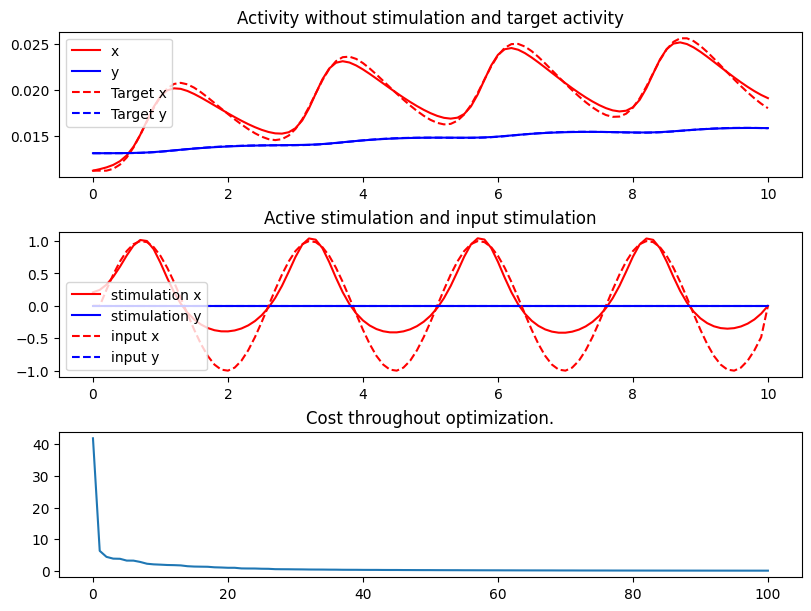

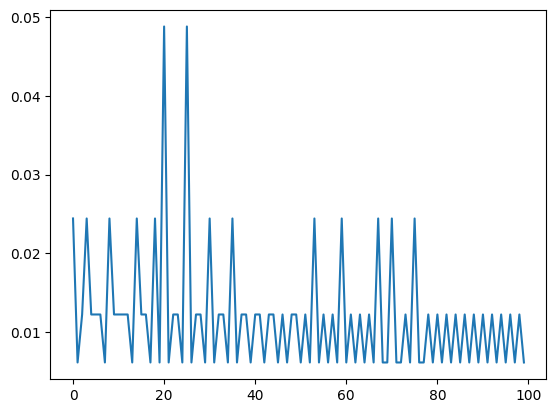

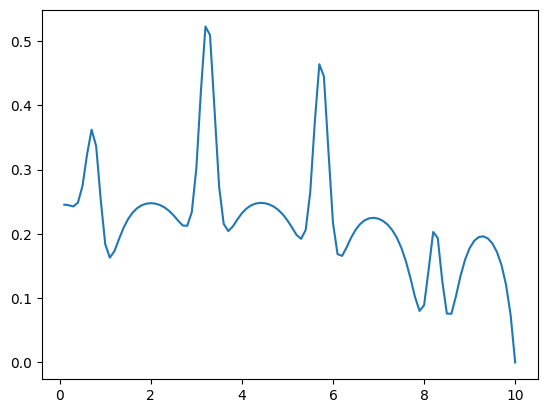

In [64]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model.params["exc_ext"] = zero_input
model.params["inh_ext"] = zero_input
controlmat = np.zeros((1,2))
controlmat[0,0] = 1.
model_controlled = oc_wc.OcWc(model, target, w_p=1, w_2=0, print_array=np.arange(0,101,1), control_matrix = controlmat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.step = 100
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

plt.plot(model_controlled.step_sizes_history)
plt.show()

plt.plot(model_controlled.model.t, model_controlled.grad[0,0,1:])
plt.show()


Compute control for a deterministic system
Cost in iteration 0: 0.10895363477958045
Cost in iteration 1: 0.10794723800139468
Cost in iteration 2: 0.10643464003475472
Cost in iteration 3: 0.1055642436373626
Cost in iteration 4: 0.10402596610628055
Cost in iteration 5: 0.10330679667710119
Cost in iteration 6: 0.10172296151499474
Cost in iteration 7: 0.10117520053794767
Cost in iteration 8: 0.09952191997538701
Cost in iteration 9: 0.09917237347307384
Cost in iteration 10: 0.09742023335898264
Cost in iteration 11: 0.0973046217310168
Cost in iteration 12: 0.0954166324807925
Cost in iteration 13: 0.09439599357949038
Cost in iteration 14: 0.09347826873695071
Cost in iteration 15: 0.09244007221196067
Cost in iteration 16: 0.09162779156985873
Cost in iteration 17: 0.09056050238703026
Cost in iteration 18: 0.08986452611046843
Cost in iteration 19: 0.08875435721321814
Cost in iteration 20: 0.0881889727391788
Cost in iteration 21: 0.08701922460027277
Cost in iteration 22: 0.086603023378545
Cost in

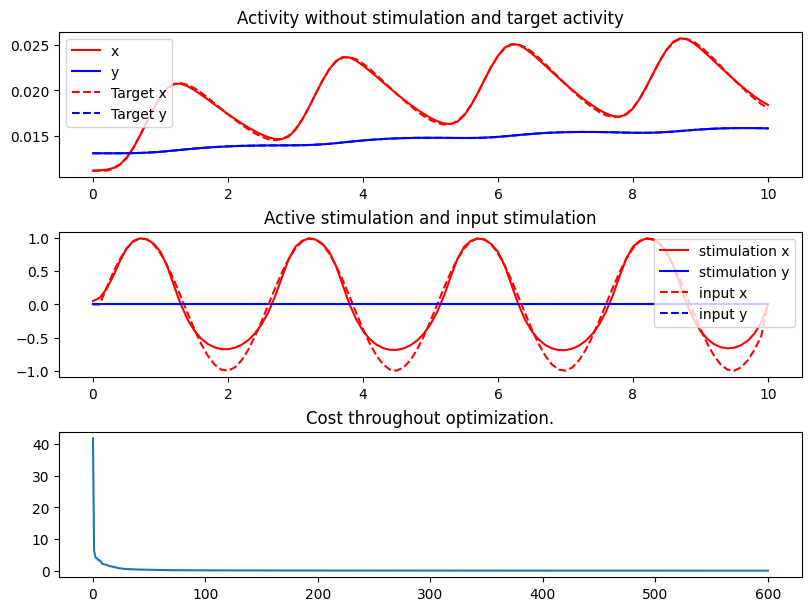

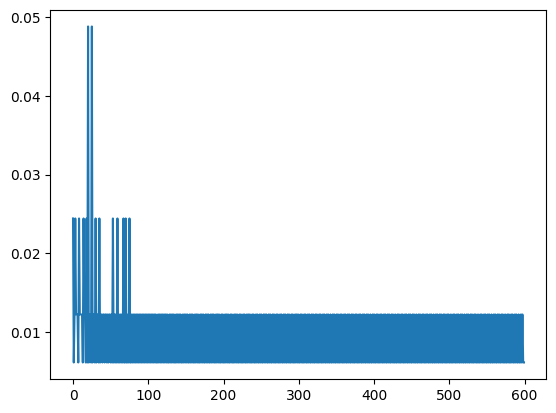

In [65]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.step = 100
model_controlled.optimize(500)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

plt.plot(model_controlled.step_sizes_history)
plt.show()

### Network case

Let us know study a simple 2-node network of model oscillators. We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

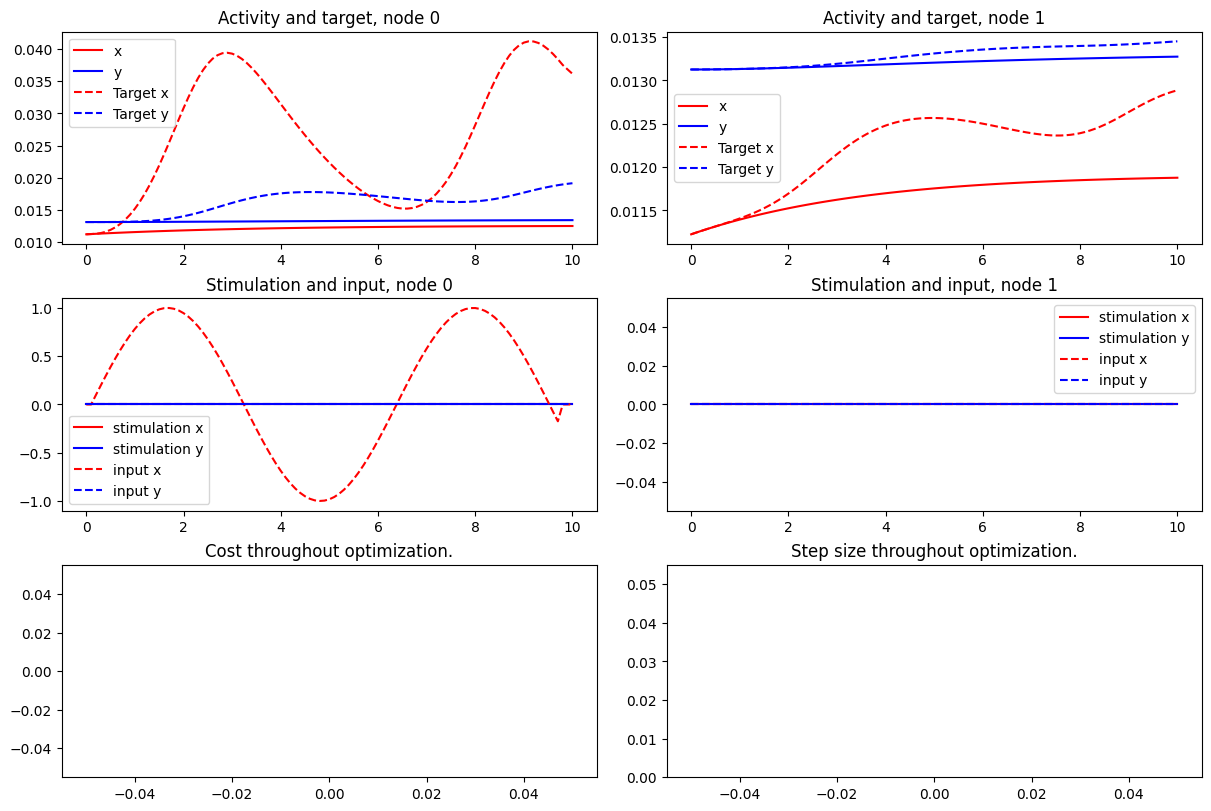

In [66]:
cmat = np.array( [[0., 1.], [0.5, 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.coupling = "additive" # use additive coupling

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

model.params.K_gl = 5.

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
model.params["exc_init"] = np.vstack( [x_init, x_init] )
model.params["inh_init"] = np.vstack( [y_init, y_init] )


# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_ext"] = input_nw[:,0,:]
model.params["inh_ext"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 1.9071368254787638e-06
Cost in iteration 1: 1.9048312161600184e-06
Cost in iteration 2: 1.9025226939031646e-06
Final cost : 1.9025226939031646e-06


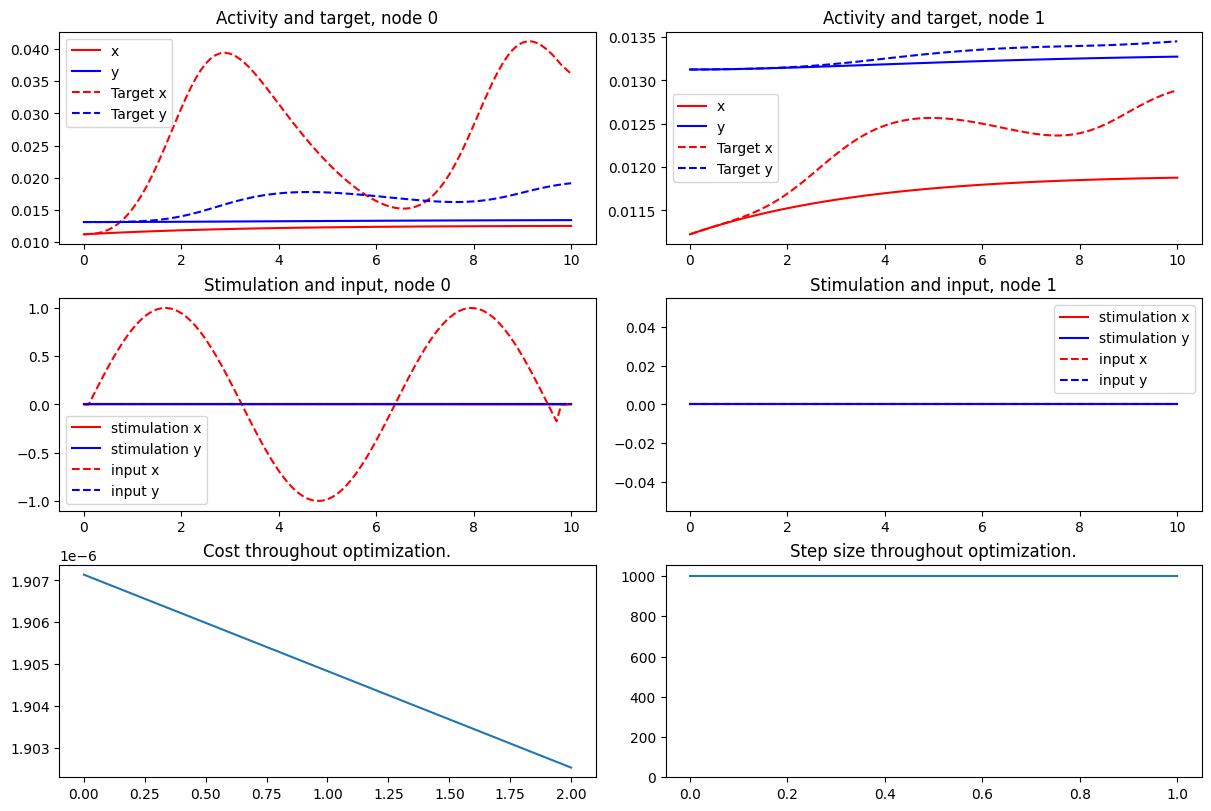

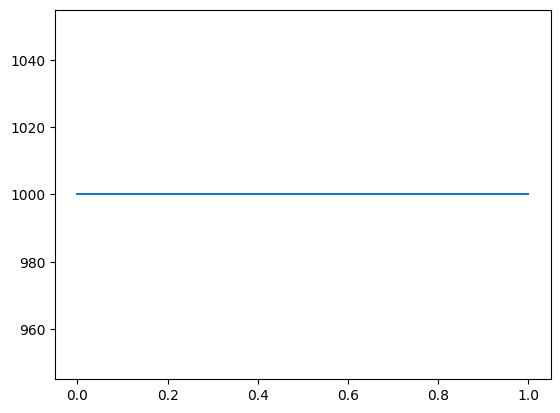

In [67]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model_controlled = oc_wc.OcWc(model, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, precision_matrix=prec_mat)

#model_controlled.step = 100
model_controlled.optimize(2)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

plt.plot(model_controlled.step_sizes_history)
plt.show()

Compute control for a deterministic system
Cost in iteration 0: 1.9025226939031646e-06
Cost in iteration 1: 1.9002112561491479e-06
Cost in iteration 2: 1.8978969003563106e-06
Cost in iteration 10: 1.879276705483465e-06
Cost in iteration 50: 1.78333131369045e-06
Cost in iteration 100: 1.656615075684336e-06
Final cost : 1.656615075684336e-06


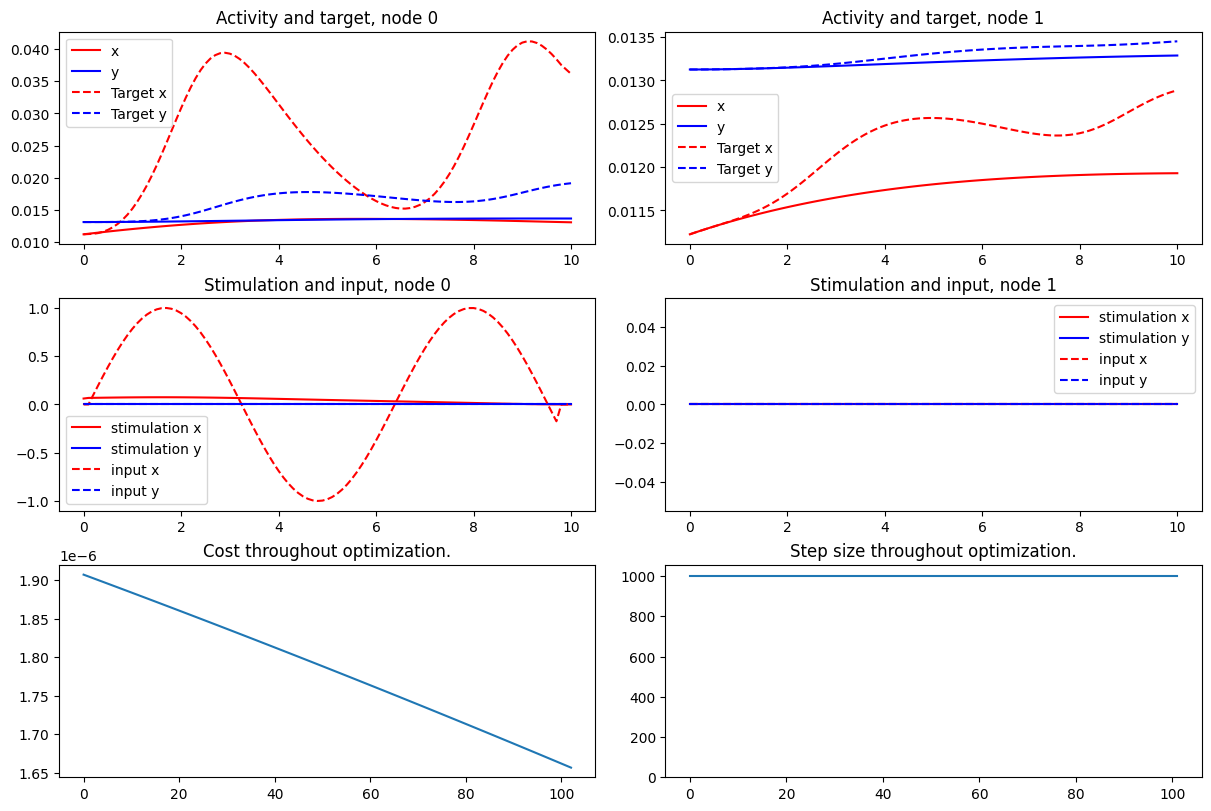

In [68]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)